# Explorative Data Analysis

Pontus' notebook for testing EDA, copy successful/good ideas to main EDA

In [2]:
# Import packages
import json
import pandas as pd  
import numpy as np
from tqdm.notebook import tqdm

(629, 7)

In [168]:
# Read data
train = pd.read_json('data/train.json', lines=True) 
test = pd.read_json('data/test.json', lines=True) 
# Divide test data into the two subsets: Private Test and Public Test
# seq_length=107 in Public Test while seq_length=130 in Private Test
test_private = test[test["seq_length"] == 107]
test_public = test[test["seq_length"] == 130]

# Print the first sample for testing
df = pd.DataFrame(train)
df.iloc[0]

index                                                                  0
id                                                          id_001f94081
sequence               GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
structure              .....((((((.......)))).)).((.....((..((((((......
predicted_loop_type    EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
signal_to_noise                                                    6.894
SN_filter                                                              1
seq_length                                                           107
seq_scored                                                            68
reactivity_error       [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...
deg_error_Mg_pH10      [0.26130000000000003, 0.38420000000000004, 0.1...
deg_error_pH10         [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...
deg_error_Mg_50C       [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...
deg_error_50C          [0.2167, 0.34750000000000003


The Kaggle challenge authors describe the different columns of the data as follows:

(copied from https://www.kaggle.com/c/stanford-covid-vaccine/data?select=sample_submission.csv)


* `id` - An arbitrary identifier for each sample.

* `seq_scored` - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of reactivity, deg_* and *_error_* columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

* `seq_length` - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of sequence. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

* `sequence` - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).

* `structure` - (1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.

* `reactivity` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.

* `deg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).

* `deg_Mg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).

* `deg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).

* `deg_Mg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).

* `*_error_*` - An array of floating point numbers, should have the same length as the corresponding reactivity or deg_* columns, calculated errors in experimental values obtained in reactivity and deg_* columns.

* `predicted_loop_type` - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop
    * `S/N filter` Indicates if the sample passed filters described in Additional Notes. (see Data under the Kaggle challenge page)


### Notes and observations about the data
Columns which describe the structure of each sample/molecule:
* The samples consists of a `sequence` of bases of length `seq_length`. The four possible bases in RNA are A, G, U and C. 
* RNA molecules have pairings between some of the bases. The estimated pairings are given by `structure`. 
    * These are however only the pairings determined to be the most likely. Alternative pairings are given by the files in the folder `bpps`, described as the *base pair probabilities* for each base-base pair in the sequence given as an adjacency matrix for each sample.  
* `predicted_loop_type` assign a loop type for each base, which describe the for that base in the sequence. For example, a paired base always (this should be confirmed with code) has loop type S for *stem loop* (see https://en.wikipedia.org/wiki/Stem-loop). Unpaired bases can have a number of different loop types, depending on the structural context of that base (how the molecule is shaped in that part of the sequence).
    * "Predicted" indicates that these are only estimated loop types for the given sequence, much like how `sequence` is the most likely pairings for the sequence. One could look further into alternative loop types for alternative structures, but in the scope of the project the provided loop type should suffice.

Columns which correspond to experimental ground truth values (targets in prediction):
* There are 5 "ground truth" values to be predicted (targets): `reactivity`, `deg_pH10`, `deg_Mg_pH10`, `deg_50C` and `deg_Mg_50C`. They are arrays of floats, where each value describe the reactivity at a given base. They are ordered in the same way as `sequence` but have length `seq_scored`, which is smaller than `seq_length`, meaning that only the first `seq_scored` bases have ground truth (target) values. This is because the reactivity values of the final bases in the sequence can't be measured experimentally due to technical limitations.
* Targets with names `deg_*` describe the likelihood of degradation at the base (my interpretation being the likelihood of the molecule breaking at that node), where `*` specify the conditions for the degradation rates (i.e. at 50 degrees Celcius, or in pH 10). The reactivity values in `reactivity` describe the likely *secondary structure* of the RNA molecule. ("Secondary structure" is a technical term, see https://en.wikipedia.org/wiki/Nucleic_acid_secondary_structure). For the purposes of this project, the 5 target values can be seen as parameters which are important for understanding the degradation of RNA molecules.
* The 5 ground truths/targets also have corresponding vectors `reactivity_error`, `deg_error_pH10` etc., which are estimated experimental errors for the reactivity values. These could be ignored initially, but are likely useful for model performance if included in some relevant way.

Note that `test.json` includes both the Public Test and Private Test data. The two subsets have to be separated by looking at the `seq_length` variable, which should be `107` for Public Test and `130` for Private Test.

Also note the signal to noise, and the SN filter (these are described further on the Kaggle challenge page). Possibly want to exculde the "noisy" samples. 

### In summary
* Each data sample is a sequence of `seq_length` bases
* Each base `i` has the following features
    * `sequence[i]`: char, possible values are `A`, `G`, `U`, `C`
    * `predicted_loop_type[i]`: char, possible values are `S`, `M`, `I`, `B`, `H`, `E`, `X`
    * `sequence[i]`: char, possible values are `.`, `(`, `)`
* The first `seq_scored` bases of the sequence have five ground truth target values each, as well as experimental errors for those five target values
    * `reactivity[i]`, `deg_pH10[i]`, `deg_Mg_pH10[i]`, `deg_50C[i]` and `deg_Mg_50C[i]`: floats, ground truth values for base `i`
    * `reactivity_error[i]`, `deg_error_pH10[i]`, `deg_error_Mg_pH10[i]`, `deg_error_50C[i]` and `deg_error_Mg_50C[i]`: floats, errors of ground truth values for base `i`


## Construct structure adjacency matrix from `structure`
This is copied and adapted from https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn.

Here, only paired bases from `(` `)` pairs are included as edges, and not the connections along the sequence between bases $(0,1)$, $(1,2)$ etc.

In [82]:
## get adjacent matrix from structure sequence

## here I calculate adjacent matrix of each base pair, 
## but eventually ignore difference of base pair and integrate into one matrix
Ss = []
for i in range(len(train)):
    seq_length = train["seq_length"].iloc[i]
    structure = train["structure"].iloc[i]
    sequence = train["sequence"].iloc[i]

    cue = []
    a_structures = {
        ("A", "U") : np.zeros([seq_length, seq_length]),
        ("C", "G") : np.zeros([seq_length, seq_length]),
        ("U", "G") : np.zeros([seq_length, seq_length]),
        ("U", "A") : np.zeros([seq_length, seq_length]),
        ("G", "C") : np.zeros([seq_length, seq_length]),
        ("G", "U") : np.zeros([seq_length, seq_length]),
    }
    a_structure = np.zeros([seq_length, seq_length])
    for i in range(seq_length):
        if structure[i] == "(":
            cue.append(i)
        elif structure[i] == ")":
            start = cue.pop()
#                 a_structure[start, i] = 1
#                 a_structure[i, start] = 1
            a_structures[(sequence[start], sequence[i])][start, i] = 1
            a_structures[(sequence[i], sequence[start])][i, start] = 1
    
    a_strc = np.stack([a for a in a_structures.values()], axis = 2)
    a_strc = np.sum(a_strc, axis = 2, keepdims = True)
    Ss.append(a_strc)

Ss = np.array(Ss)
print(Ss.shape)

(2400, 107, 107, 1)


The resulting adjacency matrix is stored as `Ss`. 
All pairs are treated equally, the `("A", "U")` arrays are concatenated into one adjacency matrix.

The shape of `Ss` is `(number_of_samples, seq_length, seq_length, 1)`.
In their implementation, the last dimension is later used for stacking multiple adjacency matrices with different information, e.g. distance adjacency matrix and base-pair probability adjacency matrices.

In [83]:
# Check number of pairs (edges)
np.sum(Ss[0,:,:,0] == 1)

46

In [84]:
# Count number of "(", should be half of number of pairs
np.sum(Ss[0,:,:,0] == 1)
counter_left_pair = 0
for char in train["structure"].iloc[0]:
  if char == "(":
    counter_left_pair += 1
counter_left_pair

23

In [85]:
Ss[0,:,:,0]
struct_adj = Ss[0,:,:,0] # Reshape to (seq_length,seq_length)

### Rewrite function that creates adjacency matrix, only including necessary steps

In [174]:
def get_struct_adj(data = train, sequential_edges = False):
    # Get adjacency matrix from sample structure sequence
    # Include edges between base pairs
    # If sequential_edges == False, do not include edges between sequential bases
    # If sequential_edges == True, add these edges, which correspond to the diagonals -1 and 1 in the adjacency matrix (assuming undirected edges)
    struct_adj = []
    for ix in range(len(data)):
        seq_length = data["seq_length"].iloc[ix]
        structure = data["structure"].iloc[ix]
        sequence = data["sequence"].iloc[ix]

        queue = [] # Store indices corresponding to "(" in queue

        sample_struct_adj = np.zeros([seq_length, seq_length])
        for jx in range(seq_length):
            if structure[jx] == "(":
                queue.append(jx) # Append index of "(" in base pair to queue
            elif structure[jx] == ")":
                start = queue.pop() # Retrieve index of last "(" in queue, corresponding to ")" at jx
                sample_struct_adj[start, jx] = 1 # Add edge from "(" to ")"
                sample_struct_adj[jx, start] = 1 # Add edge from ")" to "(" (assume undirected)

        if sequential_edges == True:
            ones = np.ones(seq_length-1) # Match length of -1 and 1 diagonals in sample_struct_adj
            sample_struct_adj += np.diag(ones,1) # Add sequential edges (i,i+1) 
            sample_struct_adj += np.diag(ones,-1) # Add sequential edges (i+1,i) (assume non-directed)

        struct_adj.append(sample_struct_adj)

    struct_adj = np.array(struct_adj)
    return struct_adj 

In [175]:
mySs = get_struct_adj(data = train)
print(mySs.shape)
mySs = mySs[:,:,:,np.newaxis] # Reshape to match structure adjacency from reference
print(mySs.shape)

# Check that the implementation is equivalent to reference
np.array_equal(Ss,mySs)

(2400, 107, 107)
(2400, 107, 107, 1)


True

## Try to plot the graph from adjacency matrix
Include off-diagonal ones for sequential edges

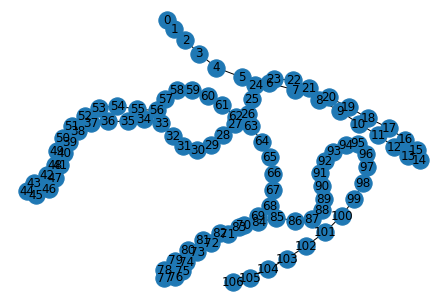

In [93]:
import networkx as nx 
  
A  =  get_struct_adj(data=train, sequential_edges=True) # Include sequential edges
A = A[0,:,:] # Take adjacency matrix of first sample

# ones = np.ones(seq_length-1)
# A += np.diag(ones,1) # add sequential edges (i,i+1) 
# A += np.diag(ones,-1) # add sequential edges (i+1,i) (assume non-directed)

G = nx.from_numpy_matrix(np.array(A))
nx.draw(G, with_labels=True)

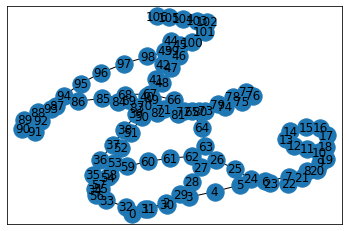

In [94]:
#  Try to make graph non-overlapping?
spring = nx.spring_layout(G)
nx.draw_networkx(G,spring)

## Look at bpps (first sample in training data)

In [74]:
a = np.load('data/bpps/id_001f94081.npy') 
print(a.shape)

(107, 107)


In [95]:
# Look at edges for one of the paired bases (row index 5)
struct_adj[5,:]
bpps_base5 = a[5,:]

In [78]:
np.where(struct_adj[5,:] == 1) # Find pair of base with index 5

(array([24], dtype=int64),)

In [96]:
np.argmax(bpps_base5) # Find maximum base pair probability for base with index 5

24

Maximum bpps value matches the true adjacency matrix (for this sample at least). Suggests that the predicted structure is based on the most likely base pairs from bpps.

## Distance matrix in reference notebook 
How the distance adjacency matrix is constructed in https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn#distance-adjhttps://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn#distance-adj

In [169]:
# Example snippet of creating distance matrix for training sample, where seq_length=107
idx = np.arange(train["seq_length"].iloc[0])
Ds = []
for i in range(len(idx)):
    d = np.abs(idx[i] - idx)
    Ds.append(d)
print(Ds[0]) # Before converting absolute index distance to distance measure
# Here Ds is a list of seq_length arrays, each with length seq_length

Ds = np.array(Ds) + 1
Ds = 1/Ds
Ds = Ds[None, :,:] # Expand the dimensions of the array to allow stacking matrices for all samples 
print(Ds.shape)
Ds = np.repeat(Ds, len(train), axis = 0) # Repeat the distance array for each sample (even though they are identical)
# Here, Ds is transformed to the distance measured and reshaped into adjacency matrices for each sample, with values being the distance measure between nodes
print(Ds.shape)

Dss = []
for i in [1, 2, 4]: 
    Dss.append(Ds ** i)
Ds = np.stack(Dss, axis = 3)
print(Ds.shape)
# Here, the power in the denominator of the distance measure expression is applied, resulting in 3 different distance adjacency matrices for each sample

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106]
(1, 107, 107)
(2400, 107, 107)
(2400, 107, 107, 3)


The distance matrices are equal for every sample in a given data set, the only inputs are the length of the sample. In the reference notebook, they use `As` (the stacked array of base-pair probability matrices) as an argument when constructing the distance matrix, but `As` is only used to determine `seq_length` and the number of samples in each data subset. The distance between bases at indices $i$ and $j$ is defined as

$$D(i,j) = \frac{1}{(|i - j| + 1)^p}$$

where $p$ is set to $1$, $2$ and $4$, giving three different measures of distance. The resulting distance adjacency matrices are stacked together with the structure adjacency matrix and the base-pair probability matrices given by the files in the `bpps` folder.

## Construct node feature vectors/arrays

Looked at node feature array in reference notebook, but things seemed overly complicated. Will implement it myself, and can compare later to make sure that everything is understood correctly.

In [201]:
def get_node_features(data = train):
    # Create a node feature matrix for each sample in data
    # Encode feature vectors as one-hot arrays  
    # Included feature: 
    #   Base (given by sequence)
    #   Loop type (given by predicted_loop_type)
    # Could also include sequence, i.e. "." "(" and ")", but I don't see how this provides any interesting information if the structure adjacency matrix is used
    X = [] # Stacked node feature matrices for all samples in data
    
    for ix in range(len(data)):
        seq_length = data["seq_length"].iloc[ix]
        sequence = train["sequence"].iloc[ix]
        predicted_loop_type = train["predicted_loop_type"].iloc[ix]

        X_sample = [] # Node feature matrix for current sample

        for jx in range(seq_length):
            # Base one hot
            bases = np.array(['A', 'G', 'U', 'C']) # Different order than reference notebook (A,G,C,U)
            x_base = np.zeros(len(bases))
            x_base[bases == sequence[jx]] = 1

            # Predicted Loop Type one hot
            loop_types = np.array(['S', 'M', 'I', 'B', 'H', 'E', 'X'])
            x_loop = np.zeros(len(loop_types))
            x_loop[loop_types == predicted_loop_type[jx]] = 1

            x = np.concatenate((x_base,x_loop))
            X_sample.append(x)
        X_sample = np.array(X_sample)
        X.append(X_sample)
    X = np.array(X)
    return X
X_tr = get_node_features(train)

In [212]:
print(X_tr.shape)
# Print feature vector of node 42 in sample 0 to see that the function assigns one hot correctly
print(X_tr[0,42])
print(train["sequence"].iloc[0][42])
print(train["predicted_loop_type"].iloc[0][42])
# First 4 are sequence one hot, last 7 are loop type one hot

(2400, 107, 11)
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
U
S


Try using reference notebook implementation of node features for comparison.

In [213]:
## sequence
def return_ohe(n, i):
    tmp = [0] * n
    tmp[i] = 1
    return tmp

def get_input(train):
    ## get node features, which is one hot encoded
    mapping = {}
    vocab = ["A", "G", "C", "U"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_node = np.stack(train["sequence"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))

    mapping = {}
    vocab = ["S", "M", "I", "B", "H", "E", "X"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_loop = np.stack(train["predicted_loop_type"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    mapping = {}
    vocab = [".", "(", ")"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_structure = np.stack(train["structure"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    
    X_node = np.concatenate([X_node, X_loop], axis = 2)
    
    ## interaction
    a = np.sum(X_node * (2 ** np.arange(X_node.shape[2])[None, None, :]), axis = 2)
    vocab = sorted(set(a.flatten()))
    print(vocab)
    ohes = []
    for v in vocab:
        ohes.append(a == v)
    ohes = np.stack(ohes, axis = 2)
    X_node = np.concatenate([X_node, ohes], axis = 2).astype(np.float32)
    
    
    print(X_node.shape)
    return X_node

X_node = get_input(train)

[17, 18, 20, 24, 33, 34, 36, 40, 65, 66, 68, 72, 129, 130, 132, 136, 257, 258, 260, 264, 513, 514, 516, 520, 1025, 1026, 1028, 1032]
(2400, 107, 39)


In [221]:
print(X_tr[0,42])
print(X_node[0,42])

[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Encoding of base and loop types are identical apart from ordering of bases (AGUC here, AGCU in reference). Reference uses one additional one-hot encoded feature called "interaction" with 28 possible values. Could look into what this is and if it is of interest.

### To do:
* Reflect on what types of GNN models might be of interest for our project. GraphConv?
* Do our own EDA, write out conclusions and ideas in notebook (work in progress)
* Understand data, understand GNN, connect the two

* Look at signal to noise, and SN filter. Should these be excluded/treated differently in training?
* Reference notebook uses `structure` as node features. I do not see how this should improve the model, as the information from `structure` is already included in the structure adjacency matrix and the predicted loop type (`"("` and `")"` correspond to loop type `"S"`).
* Reference notebook also uses an "interaction" node feature. Maybe look up in literature what this is, and if it seems interesting to include.